Initial Data:
        Control_1  Control_2  Treatment_1  Treatment_2
Gene                                                  
BRCA1         520        510          700          690
TP53          180        175          210          205
EGFR          350        340          500          510
MYC           620        610          740          730
PIK3CA        400        410          480          490
AKT1          210        220          190          180
PTEN          500        510          550          560
KRAS          600        590          650          640
NRAS          320        310          300          290
CDK2          410        405          500          495

Differential Expression Results:
     Gene  Fold_Change   P-value  Adj_P-value
0   BRCA1     1.348866  0.001621     0.007047
1    TP53     1.168098  0.013791     0.022986
2    EGFR     1.462509  0.002114     0.007047
3     MYC     1.194817  0.003518     0.008794
4  PIK3CA     1.197072  0.007866     0.015731
5    AKT1     0.

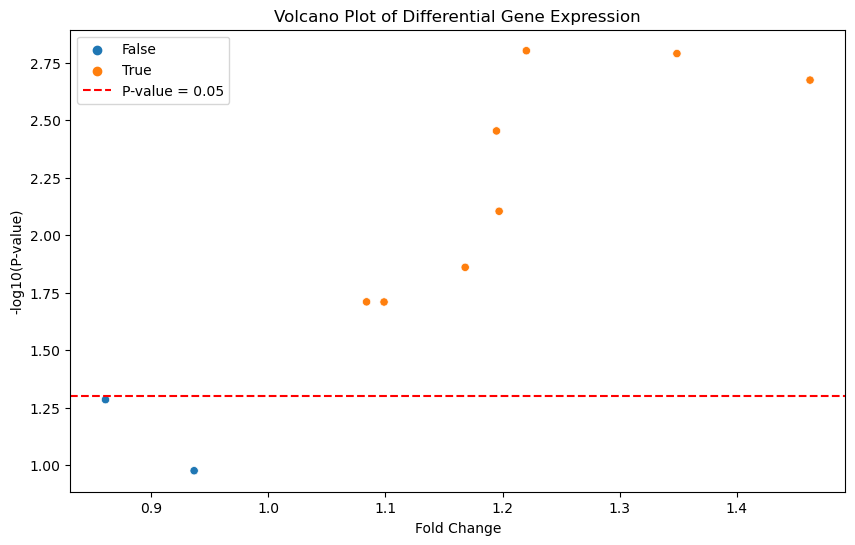

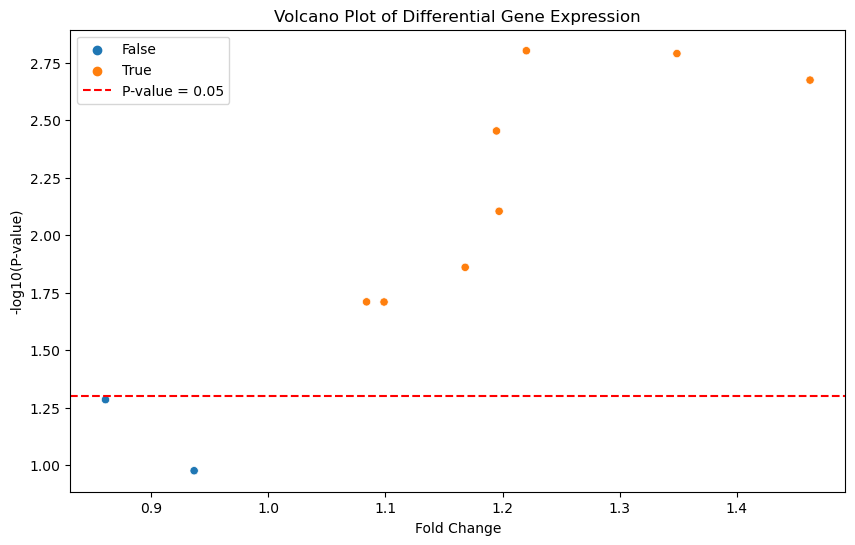

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns


# Example RNA-Seq data (replace with actual dataset)
data = {
    'Gene': ['BRCA1', 'TP53', 'EGFR', 'MYC', 'PIK3CA', 'AKT1', 'PTEN', 'KRAS', 'NRAS', 'CDK2'],
    'Control_1': [520, 180, 350, 620, 400, 210, 500, 600, 320, 410],
    'Control_2': [510, 175, 340, 610, 410, 220, 510, 590, 310, 405],
    'Treatment_1': [700, 210, 500, 740, 480, 190, 550, 650, 300, 500],
    'Treatment_2': [690, 205, 510, 730, 490, 180, 560, 640, 290, 495]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df.set_index('Gene', inplace=True)

# Preview the data
print("Initial Data:")
print(df)

# Define conditions (0 for Control, 1 for Treatment)
conditions = [0, 0, 1, 1]  # Binary encoding for Control (0) and Treatment (1)

# Perform log transformation to stabilize variance (common in RNA-Seq analysis)
df_log = np.log2(df + 1)

# Differential Expression Analysis using linear regression
results = []

for gene in df_log.index:
    # Response variable (expression levels)
    y = df_log.loc[gene].values

    # Independent variable (condition: Control vs Treatment)
    X = np.array(conditions)  # Convert conditions to a numpy array
    X = sm.add_constant(X)    # Add intercept (constant)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Store the gene, fold change (coef), and p-value
    fold_change = 2 ** model.params[1]  # Convert log2 fold change back to linear scale
    p_value = model.pvalues[1]
    results.append([gene, fold_change, p_value])

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Gene', 'Fold_Change', 'P-value'])

# Adjust for multiple testing using the False Discovery Rate (FDR)
results_df['Adj_P-value'] = multipletests(results_df['P-value'], method='fdr_bh')[1]

# Display results
print("\nDifferential Expression Results:")
print(results_df)

# Volcano plot for visualizing fold change vs significance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Fold_Change', y=-np.log10(results_df['P-value']), hue=results_df['Adj_P-value'] < 0.05)

plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='P-value = 0.05')
plt.xlabel('Fold Change')
plt.ylabel('-log10(P-value)')
plt.title('Volcano Plot of Differential Gene Expression')
plt.legend()
plt.show()